## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [29]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
#from models import Net
from models import *

#net = Net()
net = AlexNet()
print(net)

AlexNet(
  (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout2): Dropout(p=0.2)
  (dropout4): Dropout(p=0.4)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_runn

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [31]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale((250, 250)), \
                                           RandomCrop((227, 227)), \
                                           Normalize(), \
                                           ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [32]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 227, 227]) torch.Size([68, 2])
1 torch.Size([1, 227, 227]) torch.Size([68, 2])
2 torch.Size([1, 227, 227]) torch.Size([68, 2])
3 torch.Size([1, 227, 227]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [33]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [34]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [35]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [36]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net.forward(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [37]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [38]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

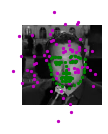

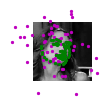

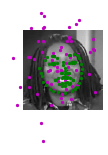

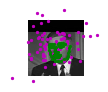

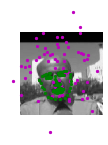

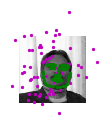

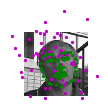

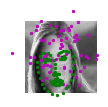

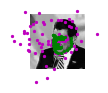

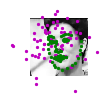

In [39]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [40]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = None
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [41]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [42]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.007575039982795715
Epoch: 1, Batch: 20, Avg. Loss: 0.006704708456993103
Epoch: 1, Batch: 30, Avg. Loss: 0.006143025398254395
Epoch: 1, Batch: 40, Avg. Loss: 0.005336107760667801
Epoch: 1, Batch: 50, Avg. Loss: 0.004798206835985184
Epoch: 1, Batch: 60, Avg. Loss: 0.004558966875076294
Epoch: 1, Batch: 70, Avg. Loss: 0.004362556159496308
Epoch: 1, Batch: 80, Avg. Loss: 0.004358292907476425
Epoch: 1, Batch: 90, Avg. Loss: 0.004283757835626602
Epoch: 1, Batch: 100, Avg. Loss: 0.003995415359735489
Epoch: 1, Batch: 110, Avg. Loss: 0.004062766373157501
Epoch: 1, Batch: 120, Avg. Loss: 0.0037388803362846373
Epoch: 1, Batch: 130, Avg. Loss: 0.003802708566188812
Epoch: 1, Batch: 140, Avg. Loss: 0.0036548216342926028
Epoch: 1, Batch: 150, Avg. Loss: 0.0035816380977630614
Epoch: 1, Batch: 160, Avg. Loss: 0.0035157703459262847
Epoch: 1, Batch: 170, Avg. Loss: 0.0034708773493766784
Epoch: 1, Batch: 180, Avg. Loss: 0.003392499715089798
Epoch: 1, Batch: 190, Avg. Loss:

Epoch: 5, Batch: 160, Avg. Loss: 0.0009360513538122177
Epoch: 5, Batch: 170, Avg. Loss: 0.0009225990399718284
Epoch: 5, Batch: 180, Avg. Loss: 0.0009230355620384217
Epoch: 5, Batch: 190, Avg. Loss: 0.000841472864151001
Epoch: 5, Batch: 200, Avg. Loss: 0.0008959784135222435
Epoch: 5, Batch: 210, Avg. Loss: 0.0008227639868855477
Epoch: 5, Batch: 220, Avg. Loss: 0.0009798168912529945
Epoch: 5, Batch: 230, Avg. Loss: 0.0008732276186347007
Epoch: 5, Batch: 240, Avg. Loss: 0.000821697298437357
Epoch: 5, Batch: 250, Avg. Loss: 0.0009079649597406388
Epoch: 5, Batch: 260, Avg. Loss: 0.000788627453148365
Epoch: 5, Batch: 270, Avg. Loss: 0.0008704520016908645
Epoch: 5, Batch: 280, Avg. Loss: 0.0007975056320428848
Epoch: 5, Batch: 290, Avg. Loss: 0.0008495101779699326
Epoch: 5, Batch: 300, Avg. Loss: 0.000779565192759037
Epoch: 5, Batch: 310, Avg. Loss: 0.0009441652968525887
Epoch: 5, Batch: 320, Avg. Loss: 0.0007907852344214917
Epoch: 5, Batch: 330, Avg. Loss: 0.0008455214761197567
Epoch: 5, Batc

Epoch: 9, Batch: 300, Avg. Loss: 0.0006040161959826947
Epoch: 9, Batch: 310, Avg. Loss: 0.0005063582286238671
Epoch: 9, Batch: 320, Avg. Loss: 0.0005030328370630741
Epoch: 9, Batch: 330, Avg. Loss: 0.0004058012403547764
Epoch: 9, Batch: 340, Avg. Loss: 0.00047488515451550486
Epoch: 10, Batch: 10, Avg. Loss: 0.0004188998248428106
Epoch: 10, Batch: 20, Avg. Loss: 0.0004743001833558083
Epoch: 10, Batch: 30, Avg. Loss: 0.0005347190499305725
Epoch: 10, Batch: 40, Avg. Loss: 0.000553540663793683
Epoch: 10, Batch: 50, Avg. Loss: 0.0004735896158963442
Epoch: 10, Batch: 60, Avg. Loss: 0.0004367089979350567
Epoch: 10, Batch: 70, Avg. Loss: 0.00036636971309781074
Epoch: 10, Batch: 80, Avg. Loss: 0.0004535708129405975
Epoch: 10, Batch: 90, Avg. Loss: 0.0005163488835096359
Epoch: 10, Batch: 100, Avg. Loss: 0.000410729119554162
Epoch: 10, Batch: 110, Avg. Loss: 0.00040626607835292817
Epoch: 10, Batch: 120, Avg. Loss: 0.00044433141872286797
Epoch: 10, Batch: 130, Avg. Loss: 0.0004454499259591103
Epoc

Epoch: 14, Batch: 70, Avg. Loss: 0.00037396856024861337
Epoch: 14, Batch: 80, Avg. Loss: 0.0003565130122005939
Epoch: 14, Batch: 90, Avg. Loss: 0.00035904561728239057
Epoch: 14, Batch: 100, Avg. Loss: 0.0003009463604539633
Epoch: 14, Batch: 110, Avg. Loss: 0.00034965352900326254
Epoch: 14, Batch: 120, Avg. Loss: 0.0003310016579926014
Epoch: 14, Batch: 130, Avg. Loss: 0.00032717527635395526
Epoch: 14, Batch: 140, Avg. Loss: 0.0002810785751789808
Epoch: 14, Batch: 150, Avg. Loss: 0.0003050926961004734
Epoch: 14, Batch: 160, Avg. Loss: 0.000407612519338727
Epoch: 14, Batch: 170, Avg. Loss: 0.0003450518064200878
Epoch: 14, Batch: 180, Avg. Loss: 0.0003999335188418627
Epoch: 14, Batch: 190, Avg. Loss: 0.00029321460612118246
Epoch: 14, Batch: 200, Avg. Loss: 0.00034276559576392173
Epoch: 14, Batch: 210, Avg. Loss: 0.0003213163185864687
Epoch: 14, Batch: 220, Avg. Loss: 0.00038522167317569253
Epoch: 14, Batch: 230, Avg. Loss: 0.00036523384042084215
Epoch: 14, Batch: 240, Avg. Loss: 0.00041624

Epoch: 18, Batch: 180, Avg. Loss: 0.0002419042568653822
Epoch: 18, Batch: 190, Avg. Loss: 0.00025210900977253915
Epoch: 18, Batch: 200, Avg. Loss: 0.00021210730820894242
Epoch: 18, Batch: 210, Avg. Loss: 0.000193513841368258
Epoch: 18, Batch: 220, Avg. Loss: 0.0003236873662099242
Epoch: 18, Batch: 230, Avg. Loss: 0.00022634314559400083
Epoch: 18, Batch: 240, Avg. Loss: 0.0001973718637600541
Epoch: 18, Batch: 250, Avg. Loss: 0.00021953494753688575
Epoch: 18, Batch: 260, Avg. Loss: 0.00022959995828568936
Epoch: 18, Batch: 270, Avg. Loss: 0.00024774492345750333
Epoch: 18, Batch: 280, Avg. Loss: 0.00021488817501813173
Epoch: 18, Batch: 290, Avg. Loss: 0.00027225237153470514
Epoch: 18, Batch: 300, Avg. Loss: 0.0002466185977682471
Epoch: 18, Batch: 310, Avg. Loss: 0.0002389487698674202
Epoch: 18, Batch: 320, Avg. Loss: 0.0002668004240840673
Epoch: 18, Batch: 330, Avg. Loss: 0.00025841284077614545
Epoch: 18, Batch: 340, Avg. Loss: 0.0002204356910660863
Epoch: 19, Batch: 10, Avg. Loss: 0.00021

Epoch: 22, Batch: 280, Avg. Loss: 0.00020962554961442947
Epoch: 22, Batch: 290, Avg. Loss: 0.00018890965357422828
Epoch: 22, Batch: 300, Avg. Loss: 0.0002115983720868826
Epoch: 22, Batch: 310, Avg. Loss: 0.0001670377440750599
Epoch: 22, Batch: 320, Avg. Loss: 0.000186220264993608
Epoch: 22, Batch: 330, Avg. Loss: 0.00018257080018520356
Epoch: 22, Batch: 340, Avg. Loss: 0.00019047839660197498
Epoch: 23, Batch: 10, Avg. Loss: 0.00018680577259510756
Epoch: 23, Batch: 20, Avg. Loss: 0.0001839717230759561
Epoch: 23, Batch: 30, Avg. Loss: 0.00020455486699938775
Epoch: 23, Batch: 40, Avg. Loss: 0.00017005086224526167
Epoch: 23, Batch: 50, Avg. Loss: 0.000141773353330791
Epoch: 23, Batch: 60, Avg. Loss: 0.00016497259680181743
Epoch: 23, Batch: 70, Avg. Loss: 0.000241452531889081
Epoch: 23, Batch: 80, Avg. Loss: 0.00023315638303756715
Epoch: 23, Batch: 90, Avg. Loss: 0.0002102040806785226
Epoch: 23, Batch: 100, Avg. Loss: 0.00019823984988033772
Epoch: 23, Batch: 110, Avg. Loss: 0.00019349613413

Epoch: 27, Batch: 40, Avg. Loss: 0.00014095574524253607
Epoch: 27, Batch: 50, Avg. Loss: 0.00015603491757065058
Epoch: 27, Batch: 60, Avg. Loss: 0.00012924169516190888
Epoch: 27, Batch: 70, Avg. Loss: 0.00013531317748129368
Epoch: 27, Batch: 80, Avg. Loss: 0.000152218678034842
Epoch: 27, Batch: 90, Avg. Loss: 0.0001560587976127863
Epoch: 27, Batch: 100, Avg. Loss: 0.00016544214636087418
Epoch: 27, Batch: 110, Avg. Loss: 0.0001388651430606842
Epoch: 27, Batch: 120, Avg. Loss: 0.0001386999893002212
Epoch: 27, Batch: 130, Avg. Loss: 0.0001634409511461854
Epoch: 27, Batch: 140, Avg. Loss: 0.00020098671596497297
Epoch: 27, Batch: 150, Avg. Loss: 0.00016491985041648148
Epoch: 27, Batch: 160, Avg. Loss: 0.00016943691112101077
Epoch: 27, Batch: 170, Avg. Loss: 0.00015147565118968487
Epoch: 27, Batch: 180, Avg. Loss: 0.00015103753469884396
Epoch: 27, Batch: 190, Avg. Loss: 0.00015621049515902996
Epoch: 27, Batch: 200, Avg. Loss: 0.00012912643887102605
Epoch: 27, Batch: 210, Avg. Loss: 0.0001117

Epoch: 31, Batch: 140, Avg. Loss: 0.00012004966754466295
Epoch: 31, Batch: 150, Avg. Loss: 0.00013454657420516015
Epoch: 31, Batch: 160, Avg. Loss: 0.00011900400044396519
Epoch: 31, Batch: 170, Avg. Loss: 0.00011037982208654285
Epoch: 31, Batch: 180, Avg. Loss: 0.00012156632170081138
Epoch: 31, Batch: 190, Avg. Loss: 0.00011829156335443258
Epoch: 31, Batch: 200, Avg. Loss: 0.00013124063471332194
Epoch: 31, Batch: 210, Avg. Loss: 0.0001446298179216683
Epoch: 31, Batch: 220, Avg. Loss: 0.00014581091655418277
Epoch: 31, Batch: 230, Avg. Loss: 0.0001383696533739567
Epoch: 31, Batch: 240, Avg. Loss: 0.00020208873506635428
Epoch: 31, Batch: 250, Avg. Loss: 0.00012001852598041295
Epoch: 31, Batch: 260, Avg. Loss: 0.0001875854814425111
Epoch: 31, Batch: 270, Avg. Loss: 0.00013479441590607166
Epoch: 31, Batch: 280, Avg. Loss: 0.00014390943944454193
Epoch: 31, Batch: 290, Avg. Loss: 0.00011853266786783933
Epoch: 31, Batch: 300, Avg. Loss: 0.000129053826443851
Epoch: 31, Batch: 310, Avg. Loss: 0.

Epoch: 35, Batch: 240, Avg. Loss: 0.00016685532080009578
Epoch: 35, Batch: 250, Avg. Loss: 0.00011663701804354787
Epoch: 35, Batch: 260, Avg. Loss: 0.00010319102182984352
Epoch: 35, Batch: 270, Avg. Loss: 0.00013206894835457206
Epoch: 35, Batch: 280, Avg. Loss: 0.00017364816181361675
Epoch: 35, Batch: 290, Avg. Loss: 0.00013093434227630496
Epoch: 35, Batch: 300, Avg. Loss: 0.00011679877107962966
Epoch: 35, Batch: 310, Avg. Loss: 0.00013480498734861612
Epoch: 35, Batch: 320, Avg. Loss: 0.0001273887916468084
Epoch: 35, Batch: 330, Avg. Loss: 0.00013125468790531157
Epoch: 35, Batch: 340, Avg. Loss: 0.00013854612596333026
Epoch: 36, Batch: 10, Avg. Loss: 0.00012807642202824354
Epoch: 36, Batch: 20, Avg. Loss: 0.0001325630326755345
Epoch: 36, Batch: 30, Avg. Loss: 0.00011494250595569611
Epoch: 36, Batch: 40, Avg. Loss: 0.00011173413693904876
Epoch: 36, Batch: 50, Avg. Loss: 0.00011260740319266915
Epoch: 36, Batch: 60, Avg. Loss: 0.00011842735484242439
Epoch: 36, Batch: 70, Avg. Loss: 0.0001

Epoch: 39, Batch: 340, Avg. Loss: 9.696173621341586e-05
Epoch: 40, Batch: 10, Avg. Loss: 0.00012005100399255753
Epoch: 40, Batch: 20, Avg. Loss: 9.658083878457546e-05
Epoch: 40, Batch: 30, Avg. Loss: 0.00014819611189886928
Epoch: 40, Batch: 40, Avg. Loss: 0.0001355711203068495
Epoch: 40, Batch: 50, Avg. Loss: 0.00011128559242933988
Epoch: 40, Batch: 60, Avg. Loss: 0.00012168121803551913
Epoch: 40, Batch: 70, Avg. Loss: 0.00010992810875177383
Epoch: 40, Batch: 80, Avg. Loss: 0.00016035645408555866
Epoch: 40, Batch: 90, Avg. Loss: 0.00010942805418744683
Epoch: 40, Batch: 100, Avg. Loss: 0.00012260762182995678
Epoch: 40, Batch: 110, Avg. Loss: 0.00010818484518676996
Epoch: 40, Batch: 120, Avg. Loss: 0.00014850668981671334
Epoch: 40, Batch: 130, Avg. Loss: 0.00014853211119771005
Epoch: 40, Batch: 140, Avg. Loss: 0.00011329107312485576
Epoch: 40, Batch: 150, Avg. Loss: 0.0001347682042978704
Epoch: 40, Batch: 160, Avg. Loss: 0.00012494764383882284
Epoch: 40, Batch: 170, Avg. Loss: 0.00012102

Epoch: 44, Batch: 100, Avg. Loss: 9.816366899758578e-05
Epoch: 44, Batch: 110, Avg. Loss: 9.782449249178171e-05
Epoch: 44, Batch: 120, Avg. Loss: 9.350219462066889e-05
Epoch: 44, Batch: 130, Avg. Loss: 8.933521015569567e-05
Epoch: 44, Batch: 140, Avg. Loss: 9.630595054477453e-05
Epoch: 44, Batch: 150, Avg. Loss: 0.00011669376632198691
Epoch: 44, Batch: 160, Avg. Loss: 0.00011013687402009964
Epoch: 44, Batch: 170, Avg. Loss: 0.00012672184407711029
Epoch: 44, Batch: 180, Avg. Loss: 0.00010648615472018719
Epoch: 44, Batch: 190, Avg. Loss: 9.582336619496345e-05
Epoch: 44, Batch: 200, Avg. Loss: 0.00011668463051319123
Epoch: 44, Batch: 210, Avg. Loss: 0.00010948300221934914
Epoch: 44, Batch: 220, Avg. Loss: 0.00012576866382732986
Epoch: 44, Batch: 230, Avg. Loss: 0.00010558058926835657
Epoch: 44, Batch: 240, Avg. Loss: 9.843341028317809e-05
Epoch: 44, Batch: 250, Avg. Loss: 0.00010679752612486481
Epoch: 44, Batch: 260, Avg. Loss: 0.00011665772832930089
Epoch: 44, Batch: 270, Avg. Loss: 0.00

Epoch: 48, Batch: 200, Avg. Loss: 8.947764569893479e-05
Epoch: 48, Batch: 210, Avg. Loss: 9.160218155011535e-05
Epoch: 48, Batch: 220, Avg. Loss: 0.00011666223173961043
Epoch: 48, Batch: 230, Avg. Loss: 0.0001337623163126409
Epoch: 48, Batch: 240, Avg. Loss: 0.00011559250438585878
Epoch: 48, Batch: 250, Avg. Loss: 9.663802525028586e-05
Epoch: 48, Batch: 260, Avg. Loss: 0.00010996137000620365
Epoch: 48, Batch: 270, Avg. Loss: 0.00012339873379096388
Epoch: 48, Batch: 280, Avg. Loss: 0.0001014940282329917
Epoch: 48, Batch: 290, Avg. Loss: 9.288218850269914e-05
Epoch: 48, Batch: 300, Avg. Loss: 0.00011028543626889587
Epoch: 48, Batch: 310, Avg. Loss: 6.94994693621993e-05
Epoch: 48, Batch: 320, Avg. Loss: 7.802407070994377e-05
Epoch: 48, Batch: 330, Avg. Loss: 0.00012588134407997133
Epoch: 48, Batch: 340, Avg. Loss: 0.00010047875484451652
Epoch: 49, Batch: 10, Avg. Loss: 8.417841838672757e-05
Epoch: 49, Batch: 20, Avg. Loss: 0.00010094933491200209
Epoch: 49, Batch: 30, Avg. Loss: 0.00011688

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [43]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


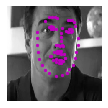

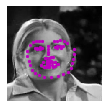

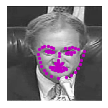

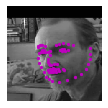

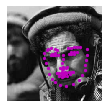

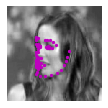

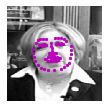

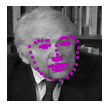

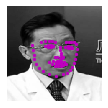

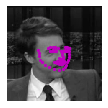

In [44]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts=None)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [45]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Optimization**: I used Adam (Adaptive momentum estimation, 2015) with learning rate of 0.001,  **𝐵1**  (1st moment) of 0.9,  **𝐵2**  (2nd moment) of 0.999 and  𝜖  of 1e-08.

- 𝐵1  of 0.9 allows us to average over the last  $1/(1−𝛽)=10$  iterations of gradient, and controls the exponentially weighted average.
- 𝐵2  comes from RMSpop (Root Mean Square Propagation) that helps tackling the oscillations.
- 𝜖  is to make sure that the RMSprop part doesn't divide by 0. Hence, to ensure numerical stability, when implementing this in practice, you add a very small epsilon
**Loss**: The outputs we are looking for are the coordinated (x, y) of the 68 keypoints of a face, coordinates are continuous values and therefore we have a regression problem.

- The Mean Squared error is a great loss function as it penalize more big errors. I first used that but noticed that the loss was excessively too high at some times
- To address the high loss, I opted for the `SmoothL1Loss` which is also known as the Huber Loss, it creates a criterion that uses a squared term if the absolute element-wise error falls below 1 and an L1 term otherwise. It is less sensitive to outliers than the `MSELoss` and in some cases prevents exploding gradients

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

I used Naimish architecture from the paper **Facial Key Points Detection using Deep Convolutional Neural Network, 2017**. 

Then I found the performance is not very good.
The next thing I have done is to search the internet to find alternative architectures. Then I found in one website(https://www.learnopencv.com/understanding-alexnet/), the author recommends to use AlexNet, so I tried this one then, the performance is better than Naimish architecture.

## Question 3: How did you decide on the number of epochs and batch_size to train your model?

I set the # of epochs to be 50.Because when I set to 10, the result is not very good.

The batch_size of 10 is enough as for each epoch we iterate over the data 320 times to update the gradients.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.04064868 -0.00984695  0.01204008 -0.06457683]
 [-0.01194536 -0.01798191 -0.03531591 -0.01063835]
 [ 0.03013431 -0.07034814  0.00708107 -0.05705396]
 [ 0.05581894 -0.03600603 -0.0678921   0.00074058]]
(4, 4)


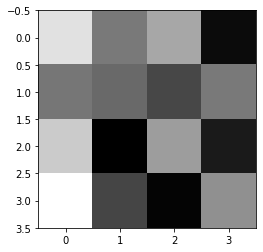

In [46]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

[[ 0.04064868 -0.00984695  0.01204008 -0.06457683]
 [-0.01194536 -0.01798191 -0.03531591 -0.01063835]
 [ 0.03013431 -0.07034814  0.00708107 -0.05705396]
 [ 0.05581894 -0.03600603 -0.0678921   0.00074058]]
(4, 4)


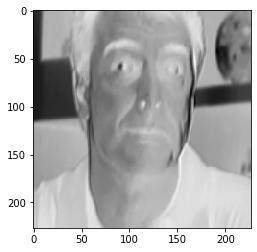

In [47]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
# plt.imshow(w[filter_index][0], cmap='gray')


idx_img = 0
img = np.squeeze(test_images[idx_img].data.numpy())

# plt.imshow(img, cmap="gray")

filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(filtered_img, cmap="gray")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) 

**The filter seems to blur out noise**

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!